<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/zero_shot_deberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import re
import spacy
from gensim import corpora, models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
nlp = spacy.load("en_core_web_sm")

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import pandas as pd

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
from transformers import pipeline
from tqdm.auto import tqdm

Version:  2.12.0
Eager mode:  True
Hub version:  0.14.0
GPU is NOT AVAILABLE


In [9]:
# Specify the path to the CSV file
csv_file_path = '/content/true_positive_experimentation.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Extract the text data from the 'text' column
text_data = df['doc_text_original'].tolist()

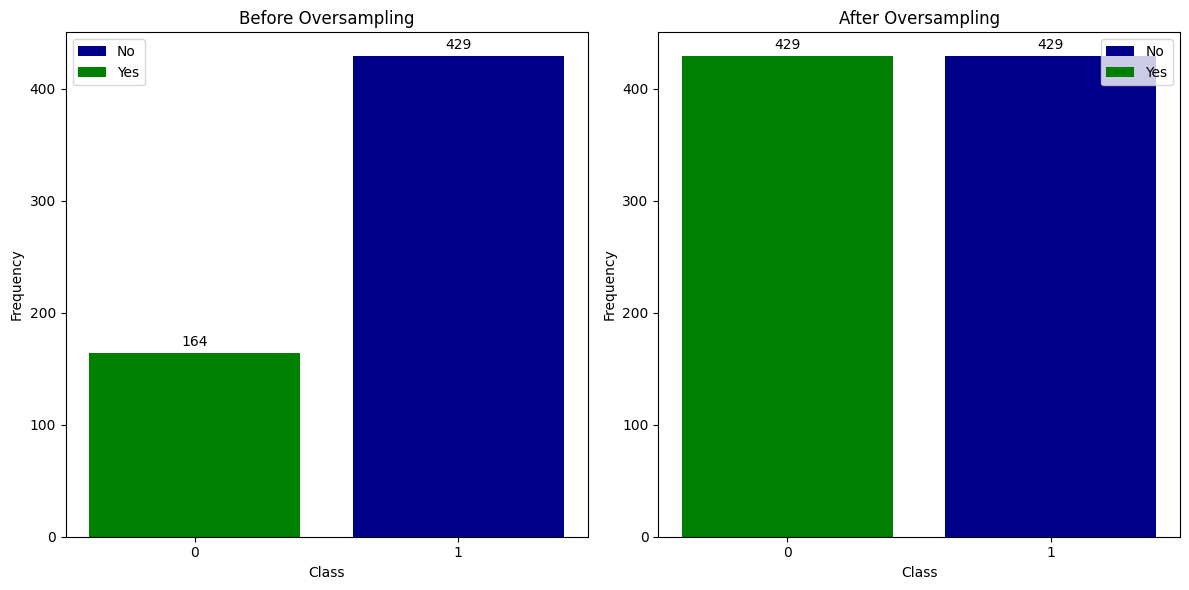

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Assuming you have the DataFrame 'df' with columns 'doc_original_text', 'dataset', and 'label_code'

# Separate the DataFrame into two classes
df_yes = df[df['label_code'] == 1]
df_no = df[df['label_code'] == 0]

# Count the number of samples in each class
count_yes = len(df_yes)
count_no = len(df_no)

# Calculate the desired oversampling ratio (e.g., making both classes have the same number of samples)
desired_ratio = 1.0  # You can adjust this ratio as needed

# Oversample the minority class ('no') to match the majority class ('yes')
oversampled_df_no = resample(df_no, replace=True, n_samples=int(desired_ratio * count_yes), random_state=42)

# Combine the oversampled DataFrames
balanced_df = pd.concat([df_yes, oversampled_df_no])

# Define colors for the bars
colors = ['darkblue', 'green']

# Plot the class distribution before and after oversampling
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Before Oversampling")
bars = plt.bar(df['label_code'].value_counts().index, df['label_code'].value_counts().values, color=colors)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1])  # Set x-axis ticks to 0 and 1
plt.legend(handles=bars, labels=["No", "Yes"])

# Add bar values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.title("After Oversampling")
bars = plt.bar(balanced_df['label_code'].value_counts().index, balanced_df['label_code'].value_counts().values, color=colors)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1])  # Set x-axis ticks to 0 and 1
plt.legend(handles=bars, labels=["No", "Yes"])

# Add bar values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [11]:
# Extract the text data from the 'text' column
text_data = balanced_df['doc_text_original'].tolist()

In [13]:
# Load the tokenizer and model
# model_name = "sileod/deberta-v3-base-tasksource-nli"
model_name = "facebook/bart-large-mnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

candidate_labels = ['yes', 'no']

# Initialize empty lists to store results
texts = []
scores_yes = []
scores_no = []
encoded_labels = []

# Set a maximum sequence length (adjust as needed)
max_length = 128

# Threshold for encoding (adjust as needed)
threshold = 0.5

# Loop through each text in text_data
for text in tqdm(text_data):
    # Tokenize and truncate/pad the text to max_length
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

    # Perform classification
    logits = model(inputs).logits

    # Calculate softmax scores
    scores = tf.nn.softmax(logits, axis=-1).numpy()[0]

    # Extract the scores for 'yes' and 'no' labels
    score_yes = scores[candidate_labels.index('yes')]
    score_no = scores[candidate_labels.index('no')]

    # Encode the label based on the threshold
    if score_yes > threshold:
        encoded_label = 1  # 'yes'
    elif score_no > threshold:
        encoded_label = 0  # 'no'
    else:
        encoded_label = 1  # Neither dominates

    # Append the results to the lists
    texts.append(text)
    scores_yes.append(score_yes)
    scores_no.append(score_no)
    encoded_labels.append(encoded_label)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2ForSequenceClassification: ['deberta.embeddings.position_ids']
- This IS expected if you are initializing TFDebertaV2ForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaV2ForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDebertaV2ForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2ForSequenceClassification for predictions without further training.


  0%|          | 0/858 [00:00<?, ?it/s]

In [23]:
# Create a DataFrame
df2 = pd.DataFrame({'Text': texts, 'Score for Label "Yes"': scores_yes, 'Score for Label "No"': scores_no, 'Encoded Label': encoded_labels, 'Original Label': balanced_df["label_code"].astype(float)})
df2

,Text,"Score for Label ""Yes""","Score for Label ""No""",Encoded Label,Original Label
0,The Statfjord reservoir is overpressured (emw ...,0.306831,0.562894,0,1.0
1,‘ The Brent reservoir is overpressured (emw 1...,0.164672,0.762545,0,1.0
2,"» Finally, the core measurements have not been...",0.110800,0.868013,0,1.0
3,Also if the pressure in the Lower Unit should ...,0.095773,0.859435,0,1.0
4,As regards the two pressures obtained in the w...,0.068871,0.901967,0,1.0
...,...,...,...,...,...
216,Commen 78.0 ure Grac “rac ec ma =S 25.9 ) — re...,0.409487,0.304236,1,0.0
305,There was no evidence in the cuttings to indic...,0.074050,0.890334,0,0.0
252,= Cavings: no indication of overpressure from ...,0.218780,0.409345,1,0.0
402,served 0 overpressure frenc \\ oQy 10 it ects ...,0.295273,0.326569,1,0.0


Confusion Matrix:
            Predicted No  Predicted Yes
Actual No            258            171
Actual Yes           354             75


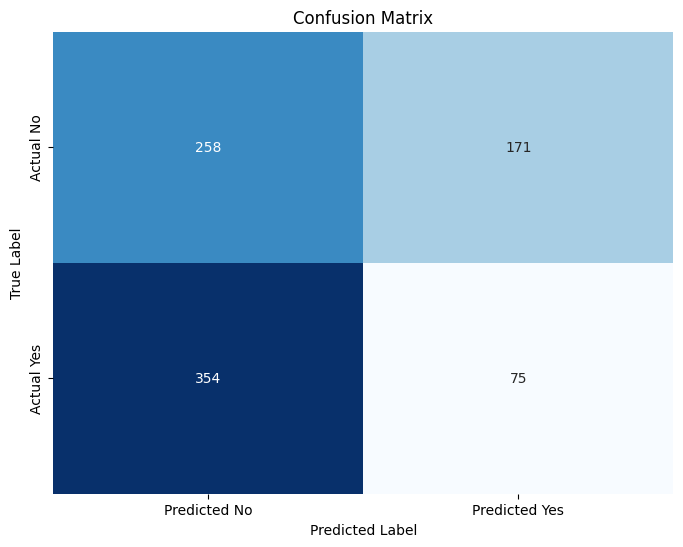

In [24]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df2' with the 'Encoded Label' and 'Original Label' columns

# Replace values outside the range [0, 1] with 0 or 1
df2['Encoded Label'] = df2['Encoded Label'].apply(lambda x: 0 if x < 0 else (1 if x > 1 else x))
df2['Original Label'] = df2['Original Label'].apply(lambda x: 0 if x < 0 else (1 if x > 1 else x))

# Extract the true labels and predicted labels (convert to integers)
true_labels = df2['Original Label'].astype(int)
predicted_labels = df2['Encoded Label'].astype(int)

# Calculate the confusion matrix (binary classification)
confusion = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame for the confusion matrix
confusion_df = pd.DataFrame(confusion, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_df)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [25]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)


Accuracy: 0.3881118881118881
Precision: 0.3048780487804878
F1 Score: 0.2222222222222222
Recall: 0.17482517482517482


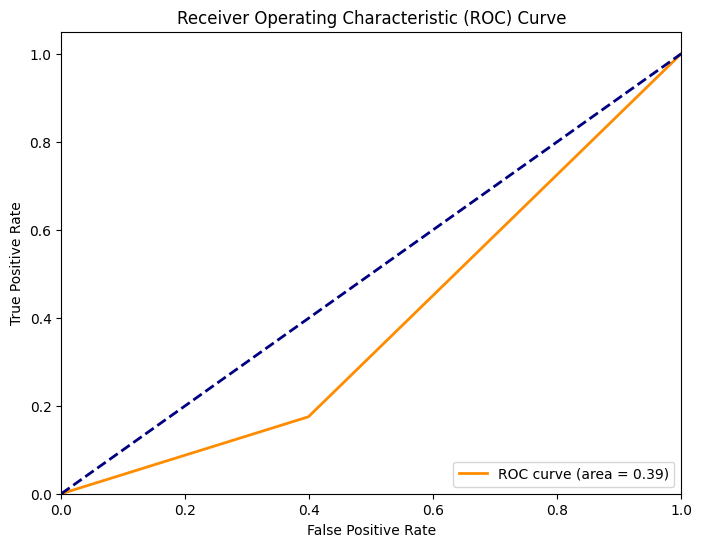

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you already have the DataFrame 'df2' with the 'Encoded Label' and 'Original Label' columns

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(true_labels, predicted_labels)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
